In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import seaborn as snss


In [ ]:
#tanbahs

In [5]:
df = pd.read_csv('https://res.cloudinary.com/daktccmqn/raw/upload/v1684995027/Crop_recommendation_dfltdn.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
# Return information about the datatype,
# NULL type of the columns of CSV file
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
labels = df['label'].unique()
print(labels)

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [23]:
def convert_label_encode(x) :
  if x == 'rice':
    return 0
  elif x == 'maize':
    return 1
  elif x == 'chickpea':
    return 2
  elif x == 'kidneybeans': 
    return 3
  elif x == 'pigeonpeas':
    return 4
  elif x == 'mothbeans':
    return 5
  elif x == 'mungbean':
    return 6
  elif x == 'blackgram':
    return 7
  elif x == 'lentil':
    return 8
  elif x == 'pomegranate':
    return 9
  elif x == 'banana':
    return 10
  elif x == 'mango':
    return 11
  elif x == 'grapes':
    return 12
  elif x == 'watermelon':
    return 13
  elif x == 'muskmelon':
    return 14
  elif x == 'apple':
    return 15
  elif x == 'orange':
    return 16
  elif x == 'papaya':
    return 17
  elif x == 'coconut':
    return 18
  elif x == 'cotton':
    return 19
  elif x == 'jute':
    return 20
  elif x == 'coffee':
    return 21


In [11]:
features = df.copy()
targets = features.pop('label')

In [25]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1408 train examples
352 validation examples
440 test examples


In [26]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    dataframe['label'] =  dataframe['label'].map(convert_label_encode)
    labels = dataframe.pop('label') 
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))#  YOUR CODE HERE
    
    if shuffle:
        ds = ds.shuffle(100) 
    ds = ds.batch(batch_size)
    return ds

In [27]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [12]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [13]:
inputs = {}

for name, column in features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.int64
  else:
    dtype = tf.float64

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'N': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'N')>,
 'P': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'P')>,
 'K': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'K')>,
 'temperature': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'temperature')>,
 'humidity': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'humidity')>,
 'ph': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'ph')>,
 'rainfall': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'rainfall')>}

In [14]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float64}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(df[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization')>

In [15]:
preprocessed_inputs = [all_numeric_inputs]

In [16]:
for name, input in inputs.items():
  if input.dtype == tf.float64:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

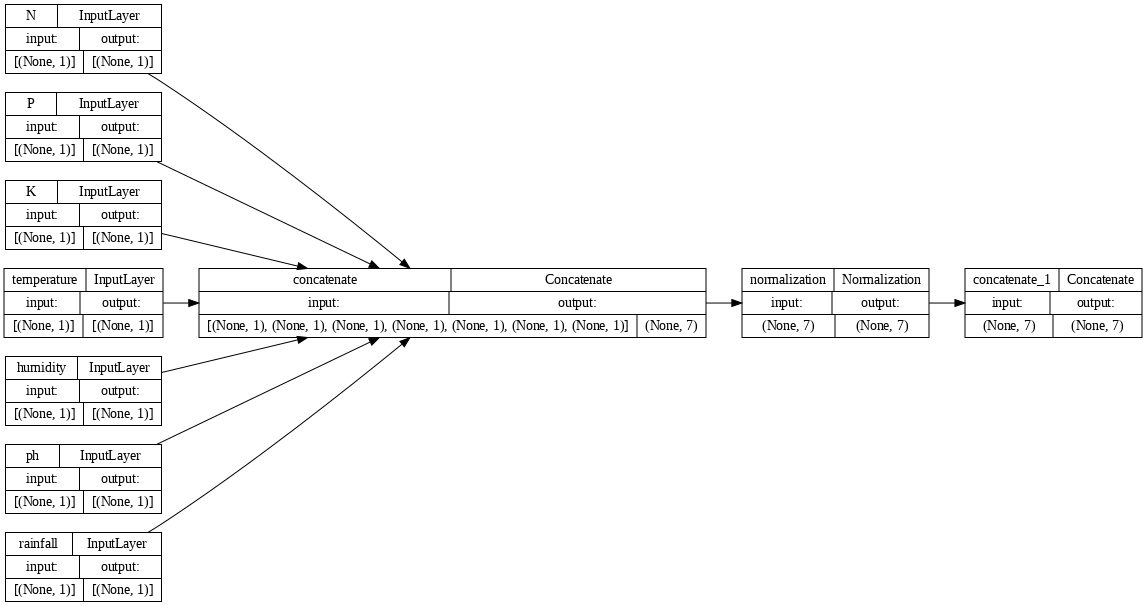

In [17]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

crop_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = crop_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [18]:
features_dict = {name: np.array(value) 
                         for name, value in features.items()}
print(features_dict)

{'N': array([ 90,  85,  60, ..., 118, 117, 104]), 'P': array([42, 58, 55, ..., 33, 32, 18]), 'K': array([43, 41, 44, ..., 30, 34, 30]), 'temperature': array([20.87974371, 21.77046169, 23.00445915, ..., 24.13179691,
       26.2724184 , 23.60301571]), 'humidity': array([82.00274423, 80.31964408, 82.3207629 , ..., 67.22512329,
       52.12739421, 60.39647474]), 'ph': array([6.50298529, 7.03809636, 7.84020714, ..., 6.36260785, 6.75879255,
       6.77983261]), 'rainfall': array([202.9355362, 226.6555374, 263.9642476, ..., 173.3228386,
       127.1752928, 140.9370415])}


In [19]:
features_dict = {name:values[:1] for name, values in features_dict.items()}
crop_preprocessing(features_dict)

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 1.0687971 , -0.34455115, -0.10168769, -0.9355875 ,  0.47266635,
         0.043302  ,  1.8103603 ]], dtype=float32)>

In [20]:
def crop_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(22),
    layers.Dense(22)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam())
  return model


In [21]:
crop_model = crop_model(crop_preprocessing, inputs)
crop_model.fit(x=features_dict, y=labels, epochs=15)

ValueError: ignored